# Inspect attention heads when using causal and bidirectional attention

In [1]:
import os
from pathlib import Path

import scipy
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

import numpy as np 

In [2]:
def load_attention_matrices(data_path, attention_type, num_layers):
    causal_attention_matrices = []

    for layer in range(num_layers):
        A = np.load(os.path.join(data_path, f"{attention_type}", f"A_layer{layer}.npy")).squeeze()
        causal_attention_matrices.append(A)

    return np.asarray(causal_attention_matrices)


In [3]:
def compute_entropies_for_all_heads_at_layer(layer, attention_matrices):
    entropies_per_head = []
    
    # collect entropies when using causal attention
    for head in range(len(attention_matrices[layer])):
        H = scipy.stats.entropy(attention_matrices[layer, head], axis=1)
        entropies_per_head.append(H)
    
    return np.asarray(entropies_per_head)

In [4]:
def compute_entropies_for_head_at_layer(layer, head, attention_matrices):    
    # collect entropies when using causal attention
    H = scipy.stats.entropy(attention_matrices[layer, head], axis=1)
    
    return np.asarray(H)

---

In [5]:
# model_name_or_path, num_layers = "EleutherAI/gpt-neo-1.3B", 24
# model_name_or_path, num_layers = "princeton-nlp/Sheared-LLaMA-1.3B", 24
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-hf", 32
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-chat-hf", 32
# model_name_or_path, num_layers = "mistralai/Mistral-7B-v0.1", 32
model_name_or_path, num_layers = "mistralai/Mistral-7B-Instruct-v0.2", 32

# transformed models
# model_name_or_path, num_layers = "vaibhavad/llama-enc", 32
# model_name_or_path, num_layers = "vaibhavad/mistral-enc", 32

In [6]:
offset = 0

In [7]:
data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"

In [8]:
causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
causal_attention_matrices.shape

(32, 32, 188, 188)

In [9]:
bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
bi_attention_matrices.shape

(32, 32, 188, 188)

In [10]:
# # DEBUGGING
# model_name_or_path, num_layers = "vaibhavad/llama-enc", 32
# data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"
# bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
# bi_attention_matrices.shape

In [11]:
# bi_attention_matrices[0, 0]

In [12]:
# # DEBUGGING
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-chat-hf", 32
# data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"
# bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
# bi_attention_matrices.shape

In [13]:
# bi_attention_matrices[0, 0]

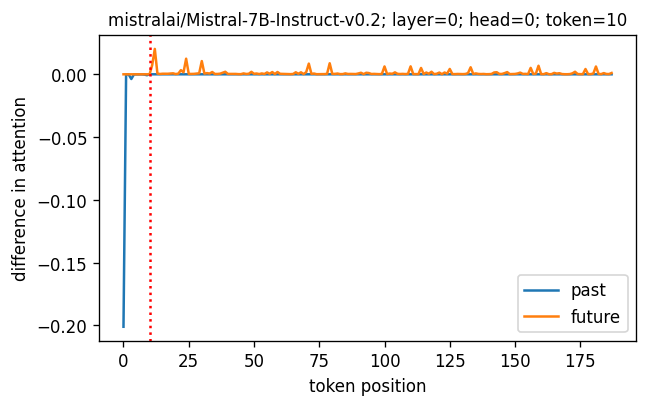

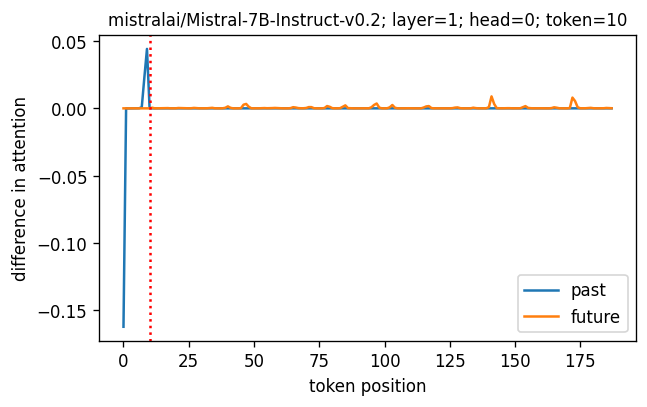

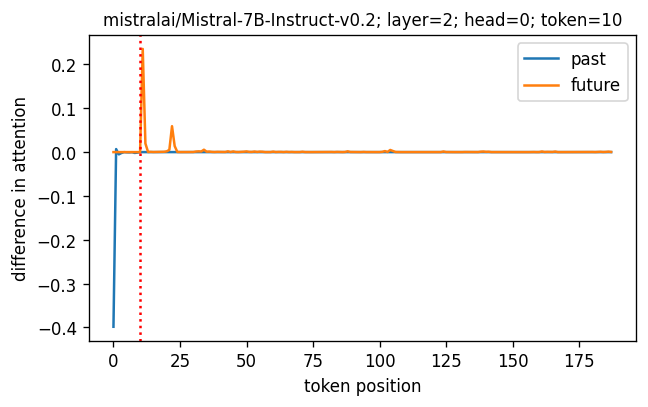

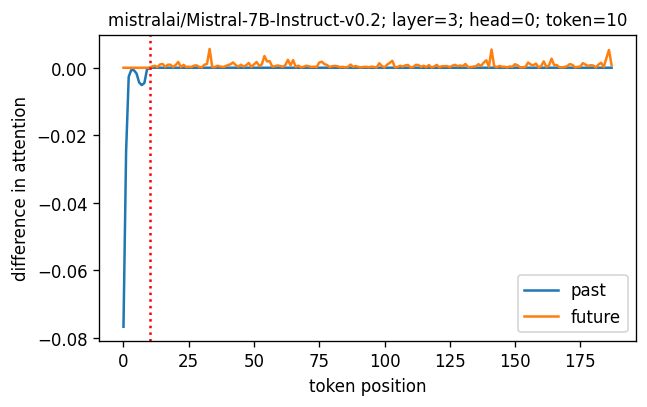

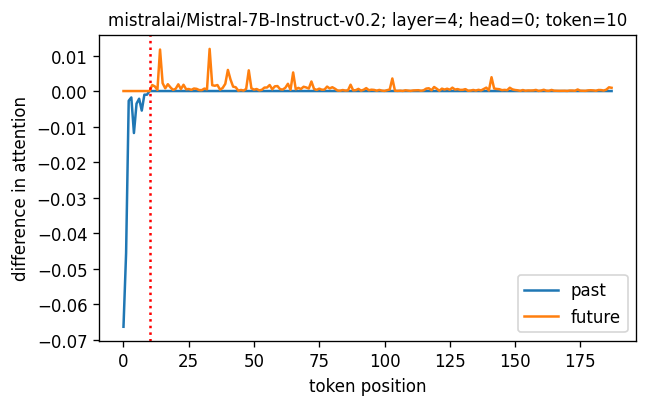

In [14]:
# plot attention distribtion for a single token position

num_tokens = causal_attention_matrices.shape[-1]

head = 0
token = 10

for layer in range(num_layers)[:5]:
    H_c = causal_attention_matrices[layer][head]
    H_b = bi_attention_matrices[layer][head]
    difference = H_b - H_c
    difference_past = np.tril(difference, k=-1)
    difference_future = np.triu(difference, k=1)

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(5.5, 3.5), dpi=120)
    axes.plot(difference_past[token, :], label="past")
    axes.plot(difference_future[token, :], label="future")
    axes.axvline(token, color="red", linestyle="dotted")

    axes.set_xlabel("token position")
    axes.set_ylabel("difference in attention")
    axes.set_title(f"{model_name_or_path}; layer={layer}; head={head}; token={token}", fontsize=10)

    axes.legend(loc="best")

    plt.tight_layout()
    plt.show()
    plt.close(); 


In [15]:
# plot entropy of each sequence position per head and layer

num_tokens = causal_attention_matrices.shape[-1]

for layer in range(num_layers)[:2]:
    H_c = compute_entropies_for_heads_at_layer(layer, causal_attention_matrices)
    H_b = compute_entropies_for_heads_at_layer(layer, bi_attention_matrices)
    
    # combine matrices
    H = np.concatenate((H_c, H_b), axis=0)
    
    print(H.shape)
    print("max. value:", np.max(H))
    print("upper bound:", np.log(num_tokens))

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(8, 5.5), dpi=120)

    im = axes.imshow(H, vmax=np.log(num_tokens), cmap="plasma")
    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.0075, label="entropy")
    # axes.axhline(H.shape[0] - 1, color="black", linewidth=2.0)

    axes.set_xlabel("token position")
    axes.set_ylabel("head")
    axes.set_title(f"{model_name_or_path}; layer={layer}")

    plt.tight_layout()
    plt.show()
    plt.close();


NameError: name 'compute_entropies_for_heads_at_layer' is not defined

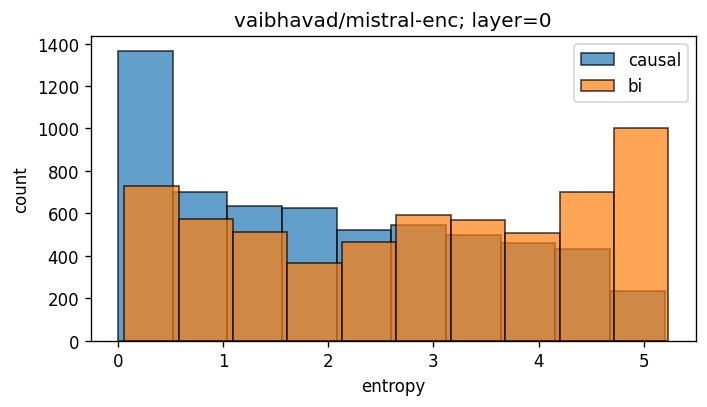

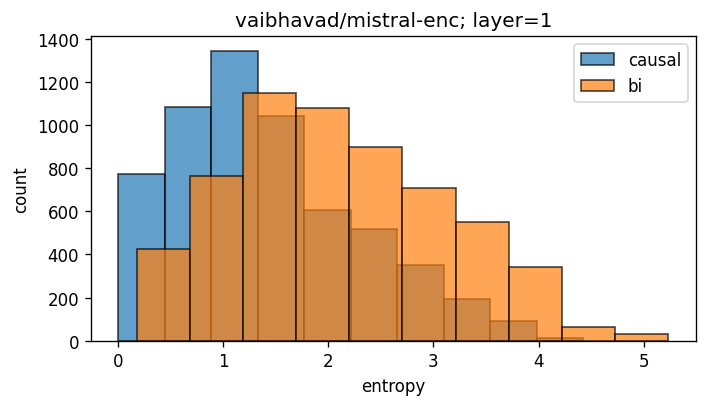

In [ ]:
for layer in range(num_layers)[:2]:
    H_c = compute_entropies_for_all_heads_at_layer(layer, causal_attention_matrices)
    H_b = compute_entropies_for_all_heads_at_layer(layer, bi_attention_matrices)

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(6, 3.5), dpi=120)

    axes.hist(H_c.flatten(), edgecolor="black", alpha=0.7, label="causal")
    axes.hist(H_b.flatten(), edgecolor="black", alpha=0.7, label="bi")

    axes.set_xlabel("entropy")
    axes.set_ylabel("count")
    
    axes.set_title(f"{model_name_or_path}; layer={layer}")
    axes.legend(loc="best")

    plt.tight_layout()
    plt.show()
    plt.close();

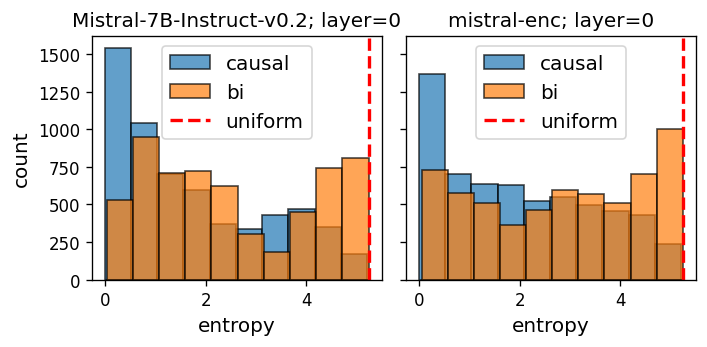

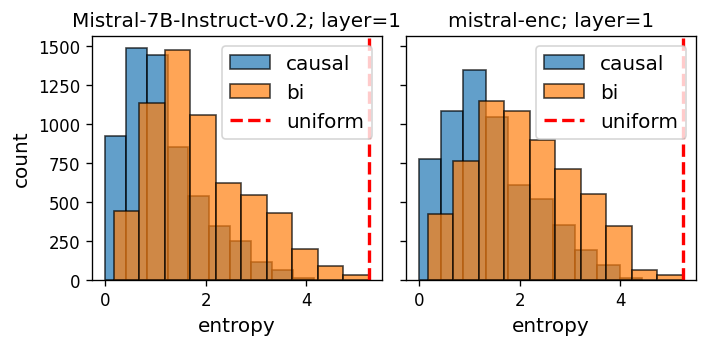

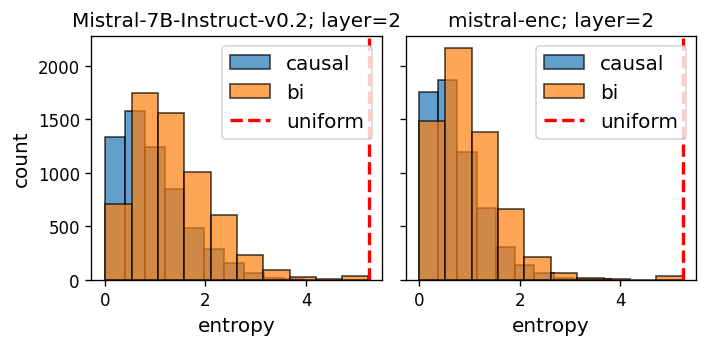

In [ ]:
# entropy distributions for two models next to each other

MODELS = [
    # ("EleutherAI/gpt-neo-1.3B", 24),
    # # ("princeton-nlp/Sheared-LLaMA-1.3B", 24),
    # ("meta-llama/Llama-2-7b-chat-hf", 32),
    # ("mistralai/Mistral-7B-v0.1", 32),
    ("mistralai/Mistral-7B-Instruct-v0.2", 32),

    # transformed models
    # ("vaibhavad/llama-enc", 32),
    ("vaibhavad/mistral-enc", 32),
]

LAYERS = np.max(np.asarray([l for _, l in MODELS])) # get largest number of layers
    
for layer in range(LAYERS)[:3]:

    fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharex=True, sharey=True, figsize=(len(MODELS) * 3.0, 3.0), dpi=120)

    for midx, (model_name_or_path, num_layers) in enumerate(MODELS):

        if layer >= num_layers:
            pass
        else:
            data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"
            causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
            bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
            
            H_c = compute_entropies_for_all_heads_at_layer(layer, causal_attention_matrices)
            H_b = compute_entropies_for_all_heads_at_layer(layer, bi_attention_matrices)

            axes[midx].hist(H_c.flatten(), edgecolor="black", alpha=0.7, label="causal")
            axes[midx].hist(H_b.flatten(), edgecolor="black", alpha=0.7, label="bi")
            axes[midx].axvline(np.log(num_tokens), color="red", linestyle="dashed", linewidth=2.0, label="uniform")

            axes[midx].legend(loc="best", fontsize=12)

        axes[midx].set_xlabel("entropy", fontsize=12)
        axes[midx].set_title(f"{model_name_or_path.split('/')[-1]}; layer={layer}", fontsize=12)

    axes[0].set_ylabel("count", fontsize=12)

    plt.tight_layout()
    plt.show()
    plt.close();

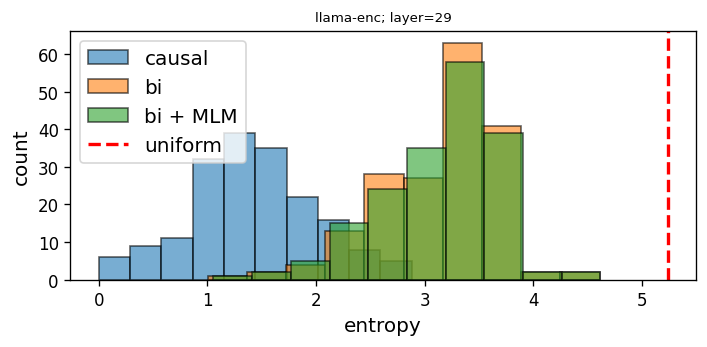

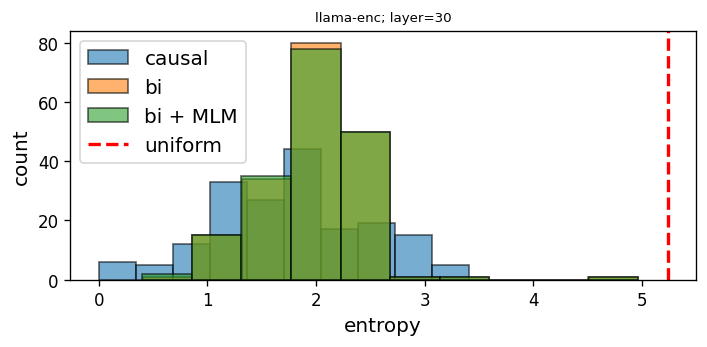

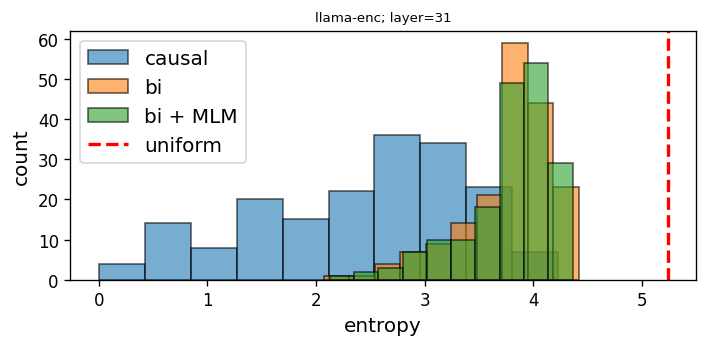

In [ ]:
# entropy distributions of original and transformed model in the same plot

MODELS = [
    # ("EleutherAI/gpt-neo-1.3B", 24),
    # # ("princeton-nlp/Sheared-LLaMA-1.3B", 24),
    ("meta-llama/Llama-2-7b-chat-hf", 32),
    # ("mistralai/Mistral-7B-v0.1", 32),
    # ("mistralai/Mistral-7B-Instruct-v0.2", 32),

    # transformed models
    ("vaibhavad/llama-enc", 32),
    # ("vaibhavad/mistral-enc", 32),
]

LAYERS = np.max(np.asarray([l for _, l in MODELS])) # get largest number of layers
    
for layer in range(LAYERS)[-3:]:

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(len(MODELS) * 3.0, 3.0), dpi=120)

    for midx, (model_name_or_path, num_layers) in enumerate(MODELS):

        if layer >= num_layers:
            pass
        else:
            data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"
            causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
            bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
            
            H_c = compute_entropies_for_head_at_layer(layer, 10, causal_attention_matrices)
            H_b = compute_entropies_for_head_at_layer(layer, 10, bi_attention_matrices)

            if "-enc" in model_name_or_path:
                axes.hist(H_b.flatten(), edgecolor="black", alpha=0.6, label="bi + MLM")
            else:
                axes.hist(H_c.flatten(), edgecolor="black", alpha=0.6, label="causal")
                axes.hist(H_b.flatten(), edgecolor="black", alpha=0.6, label="bi")

    axes.axvline(np.log(num_tokens), color="red", linestyle="dashed", linewidth=2.0, label="uniform")
    axes.set_xlabel("entropy", fontsize=12)
    axes.set_title(f"{model_name_or_path.split('/')[-1]}; layer={layer}", fontsize=8)
    axes.set_ylabel("count", fontsize=12)
    axes.legend(loc="best", fontsize=12)

    plt.tight_layout()
    plt.show()
    plt.close();

In [ ]:
# # plot a Q-Q plot comparing attention distributions

# TODO(mm): look into this more

# MODELS = [
#     # ("EleutherAI/gpt-neo-1.3B", 24),
#     # ("princeton-nlp/Sheared-LLaMA-1.3B", 24),
#     # ("meta-llama/Llama-2-7b-hf", 32),
#     ("mistralai/Mistral-7B-v0.1", 32)
# ]

# LAYERS = np.max(np.asarray([l for _, l in MODELS])) # get largest number of layers

# for layer in range(LAYERS)[:5]:

#     for midx, (model_name_or_path, num_layers) in enumerate(MODELS):

#         data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"
#         causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
#         bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
#         # restrict to future
#         bi_attention_matrices = np.triu(bi_attention_matrices, k=0)
            
#         H_b = compute_entropies_for_heads_at_layer(layer, bi_attention_matrices)
#         values = H_b.flatten()

#         fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharex=True, sharey=True, figsize=(len(MODELS) * 3.0, 2.0), dpi=120)

#         res = scipy.stats.probplot(values, sparams=(), dist='norm', fit=True, plot=axes, rvalue=False)

#         axes.set_title(f"{model_name_or_path}; layer={layer}")

#     plt.tight_layout()
#     plt.show()
#     plt.close();

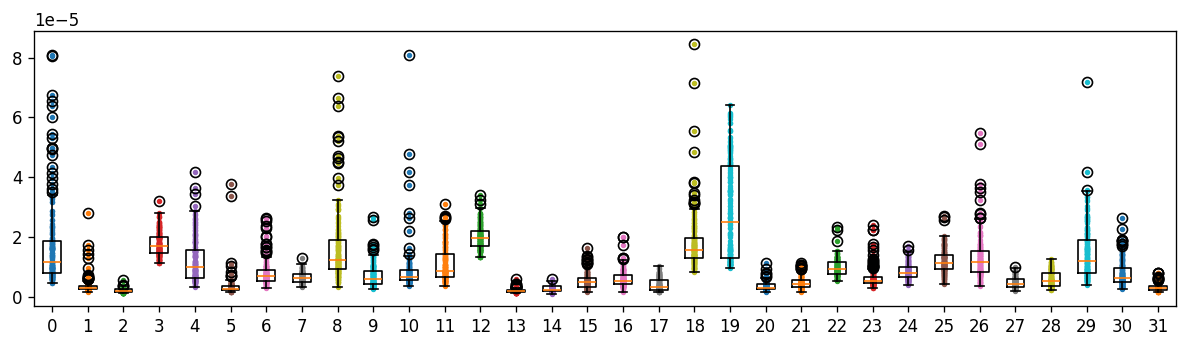

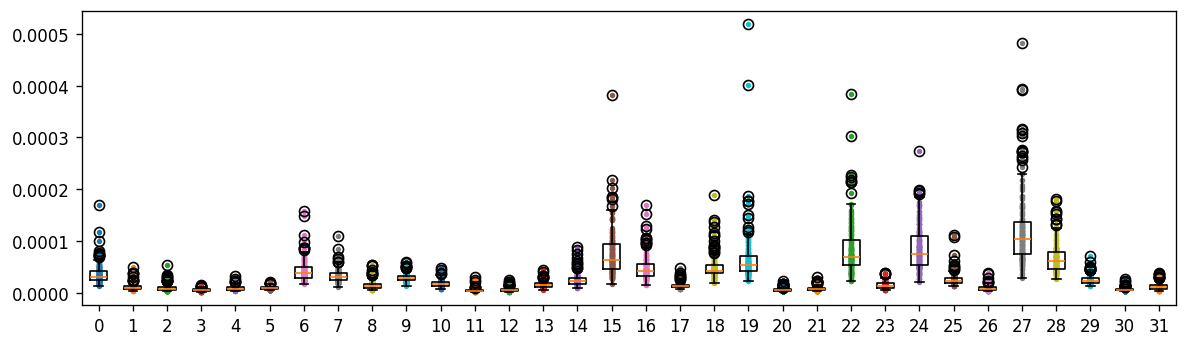

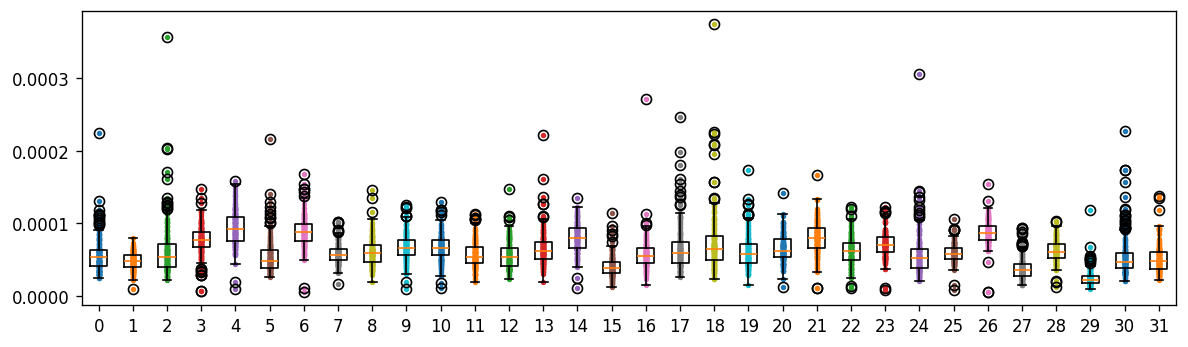

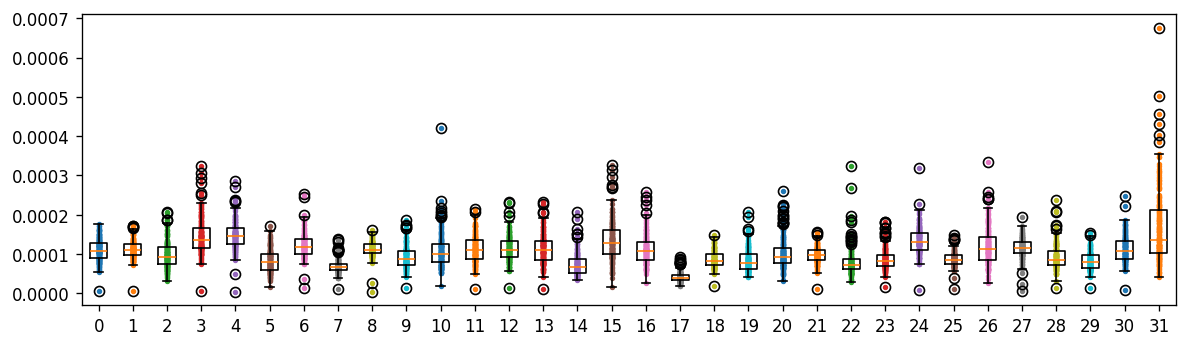

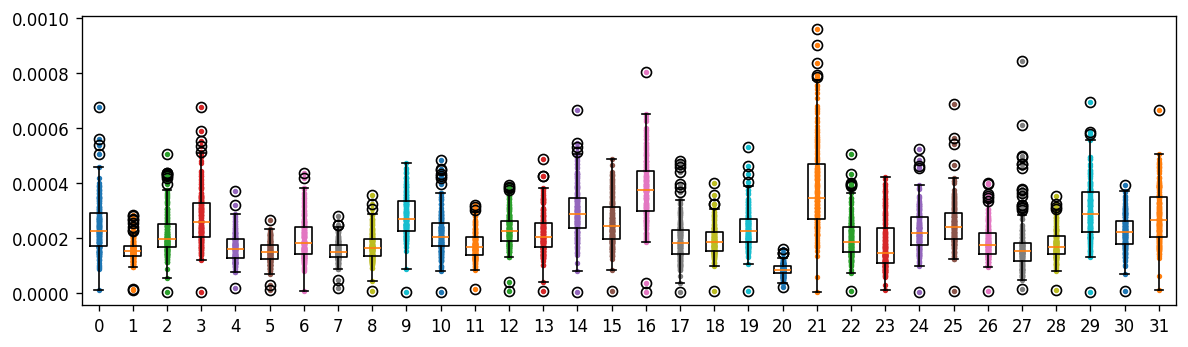

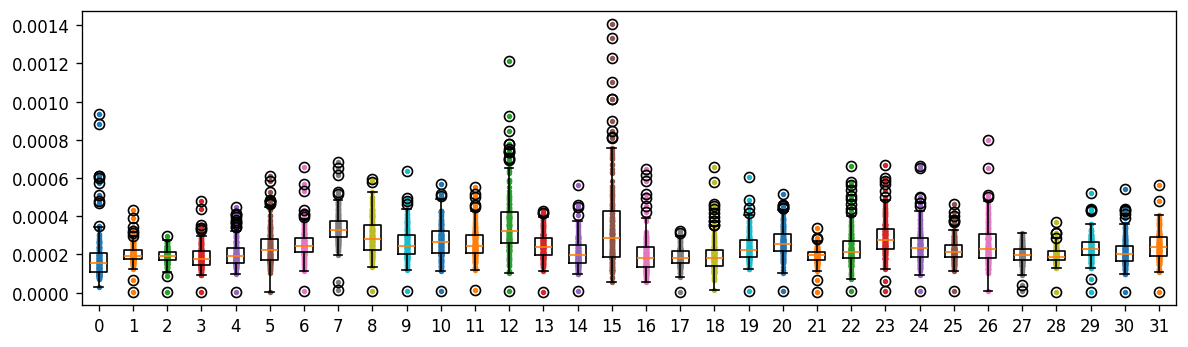

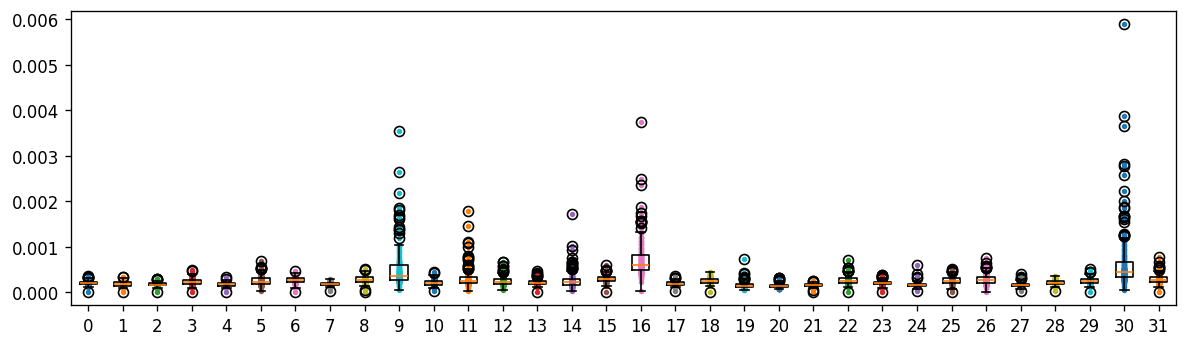

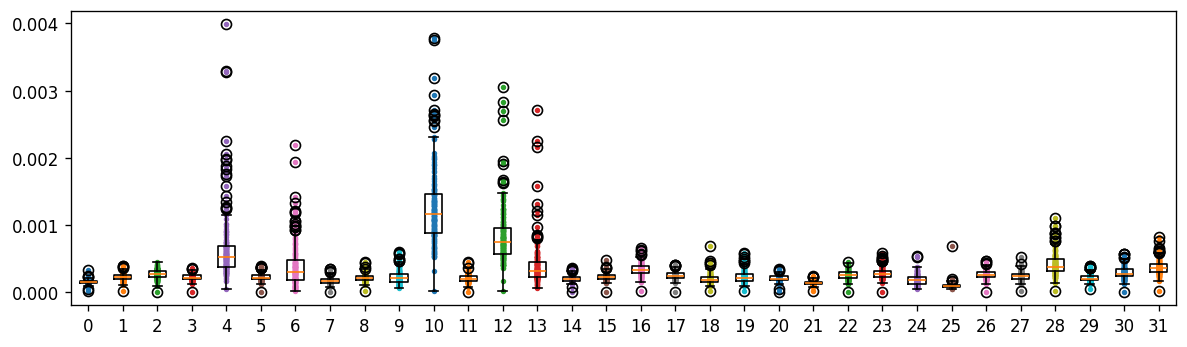

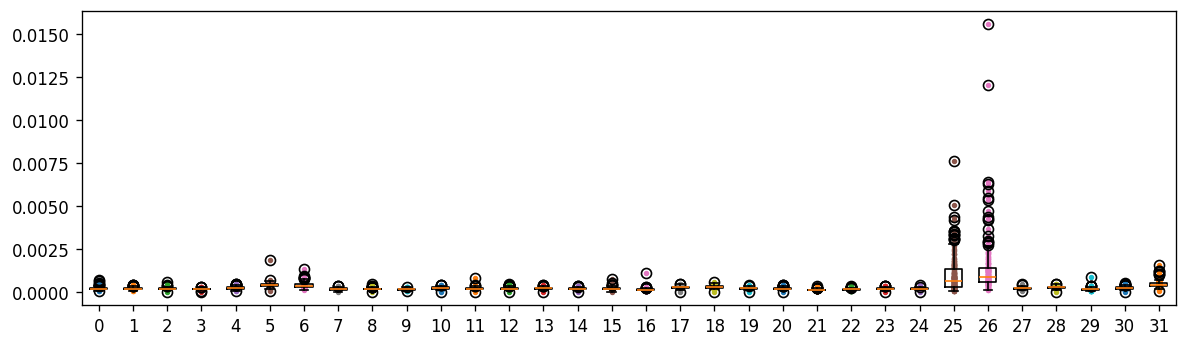

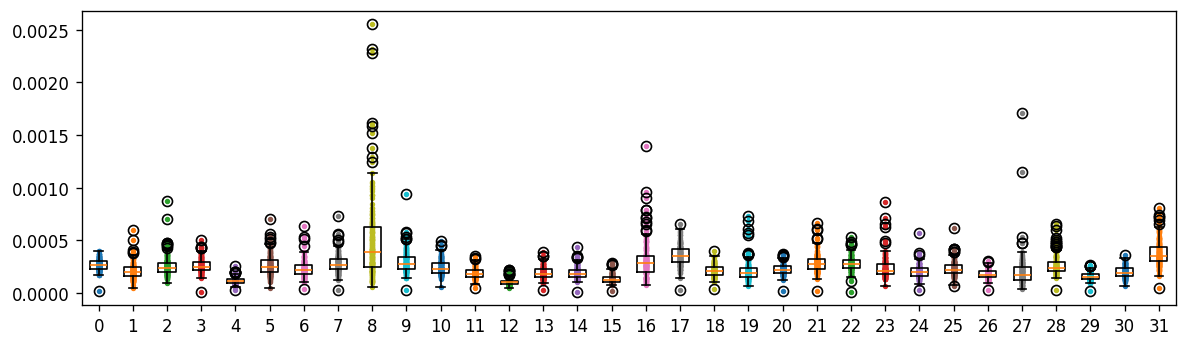

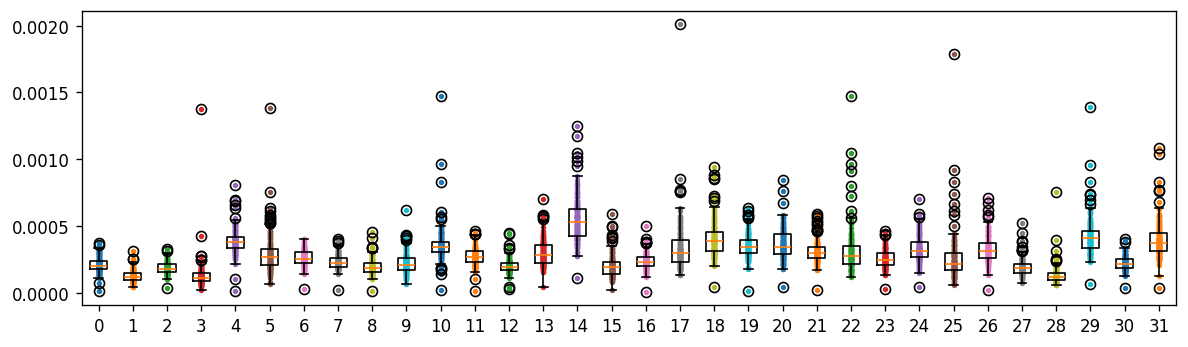

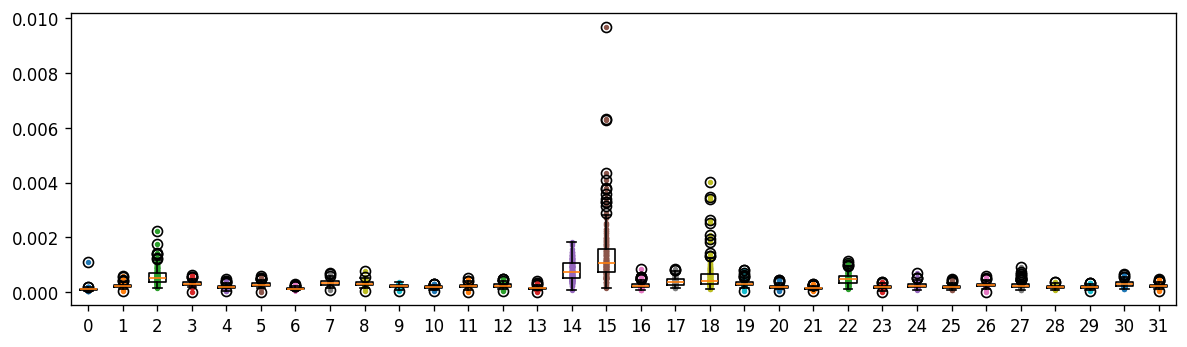

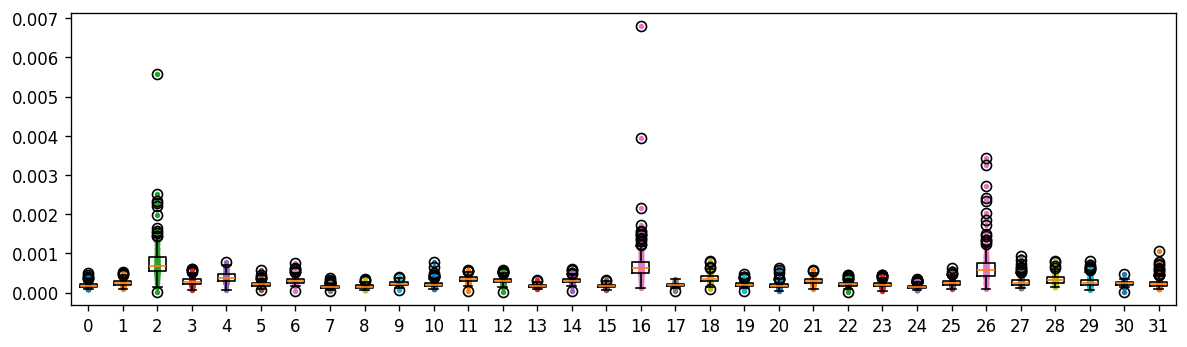

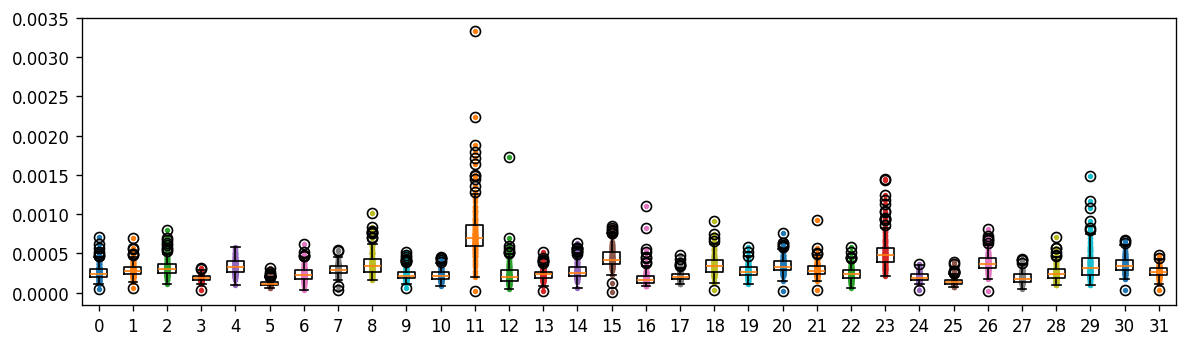

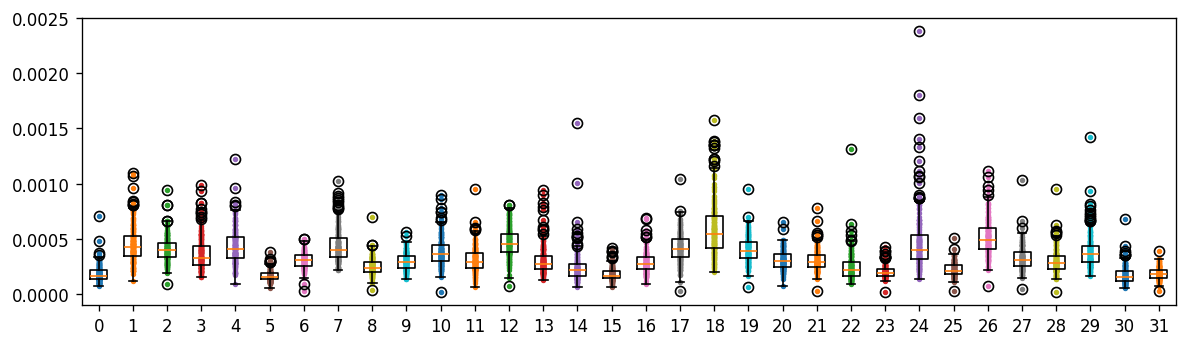

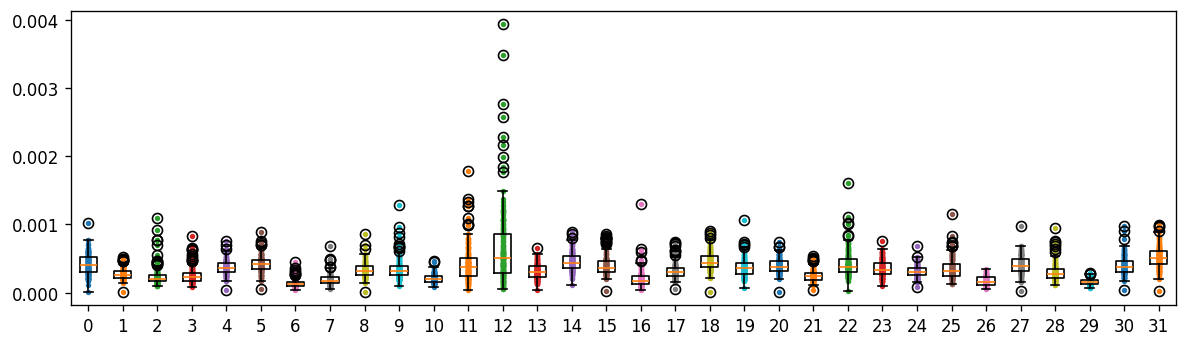

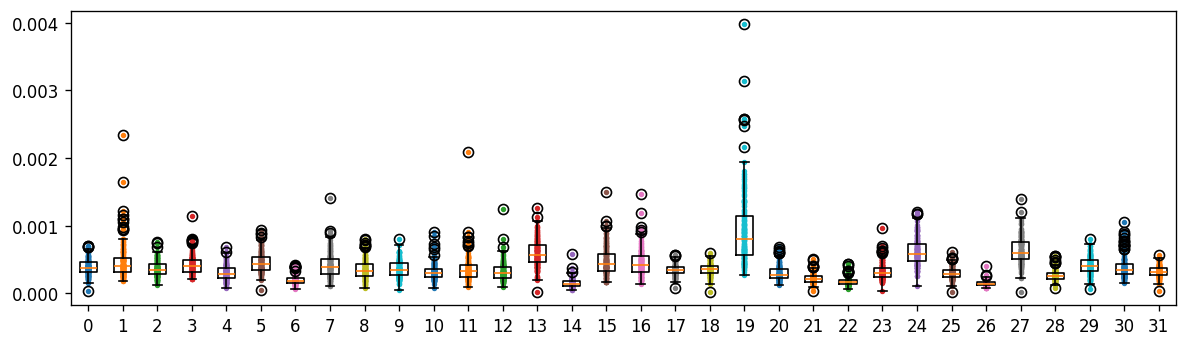

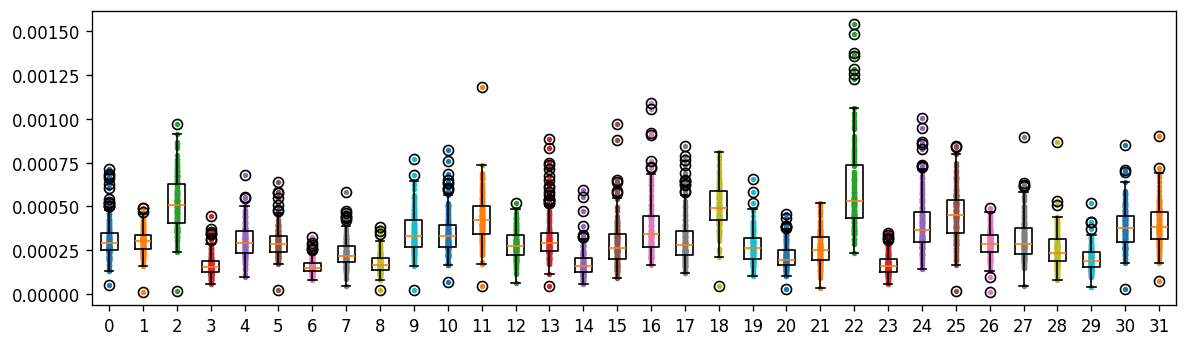

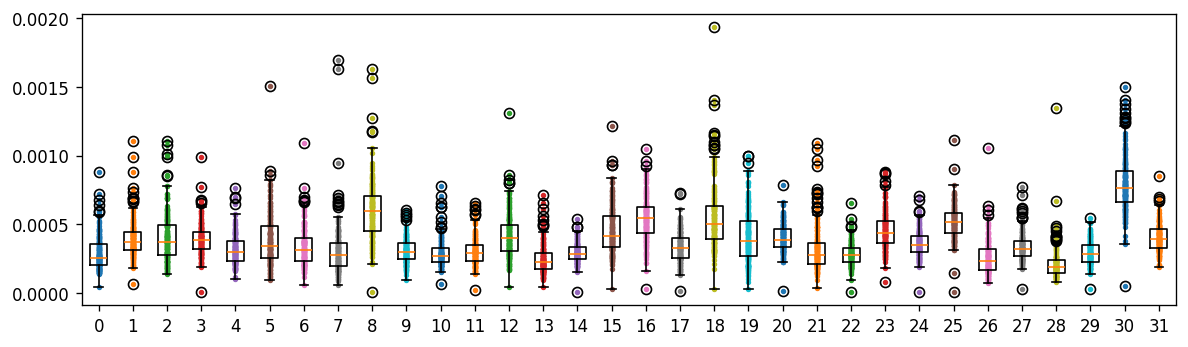

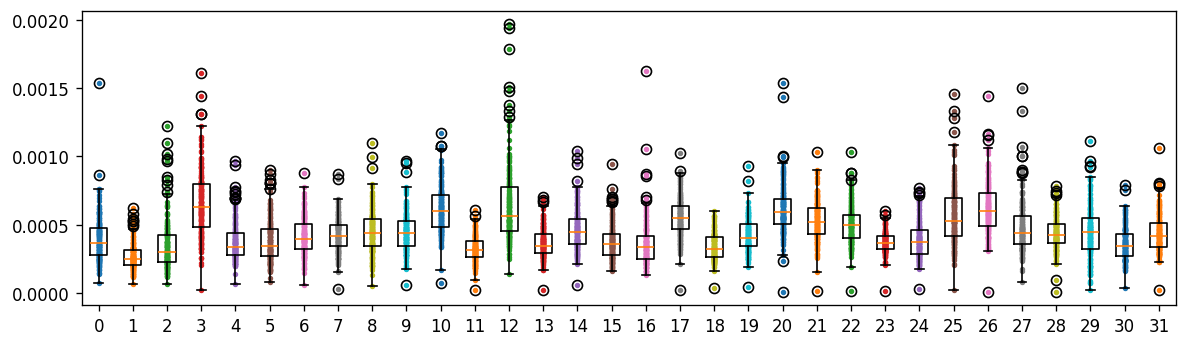

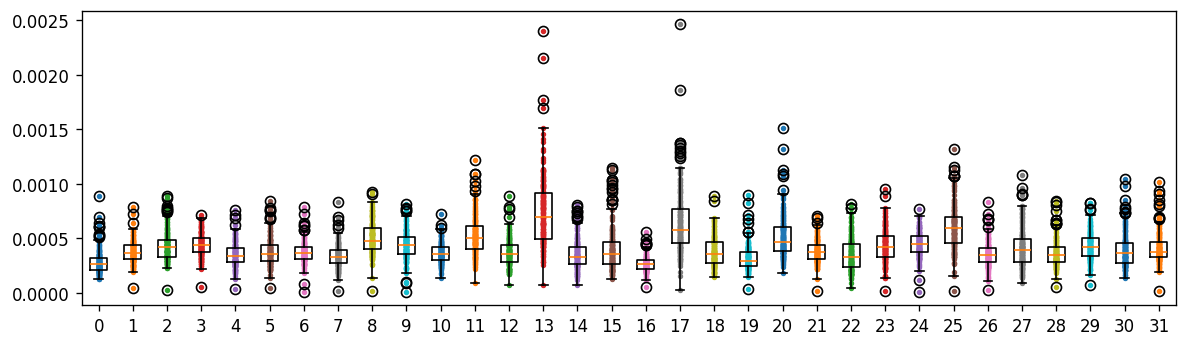

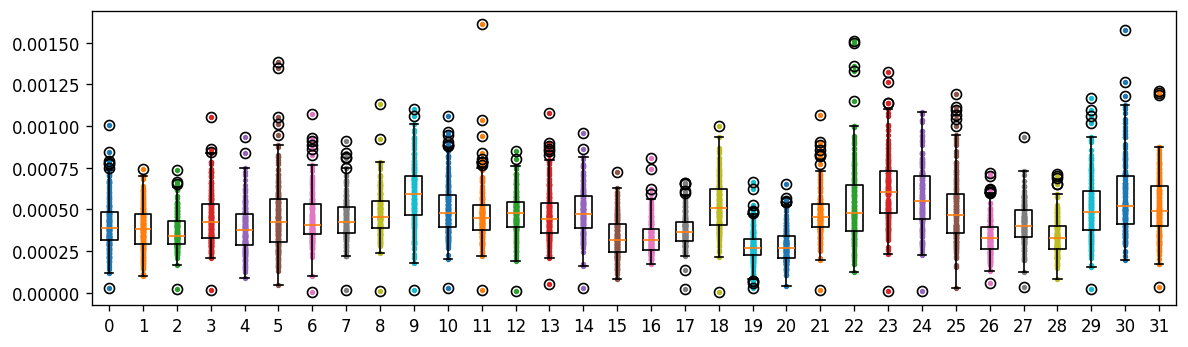

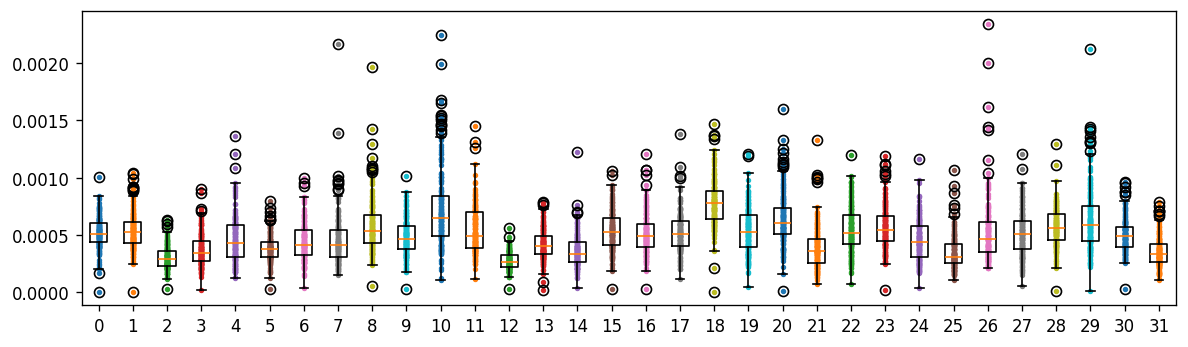

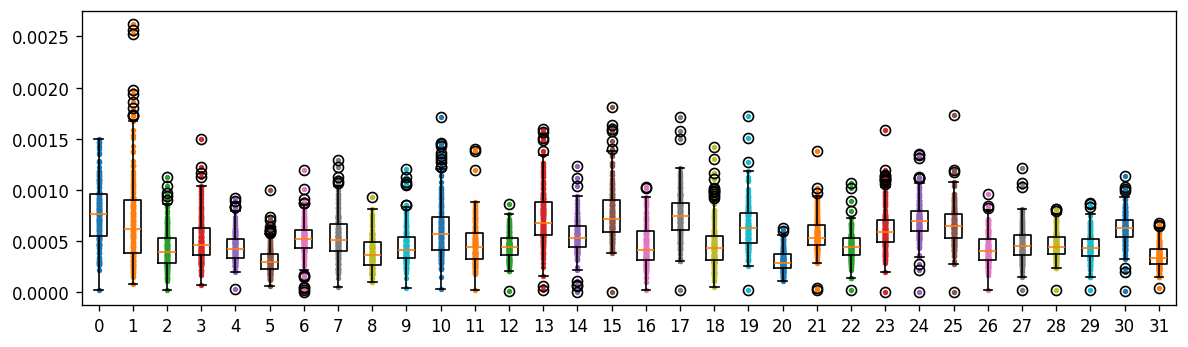

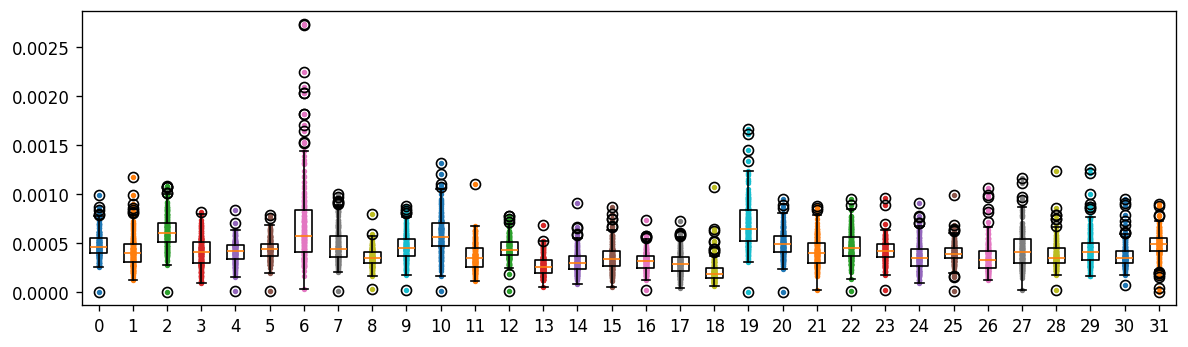

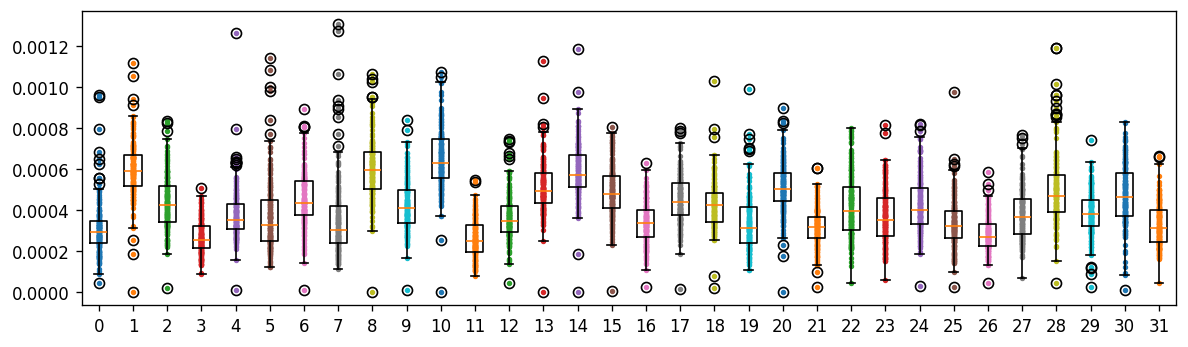

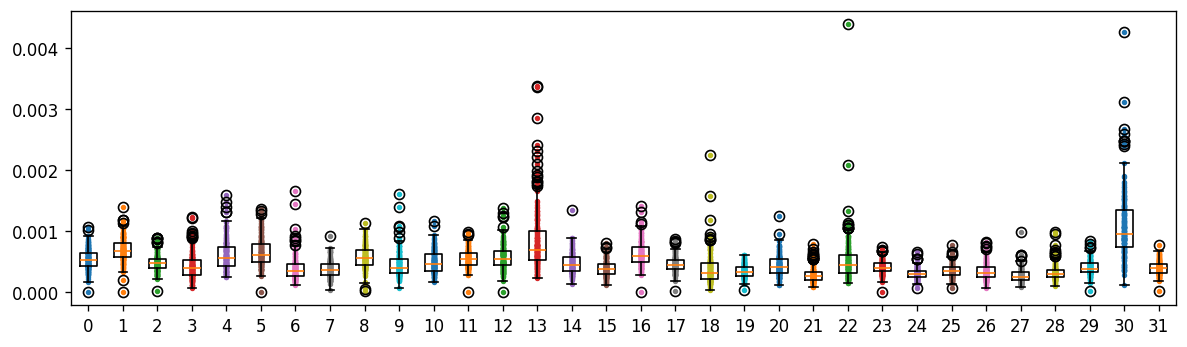

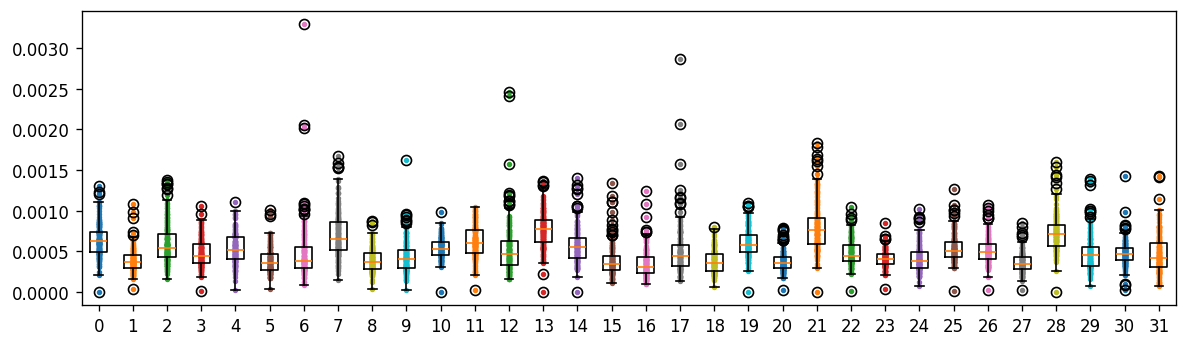

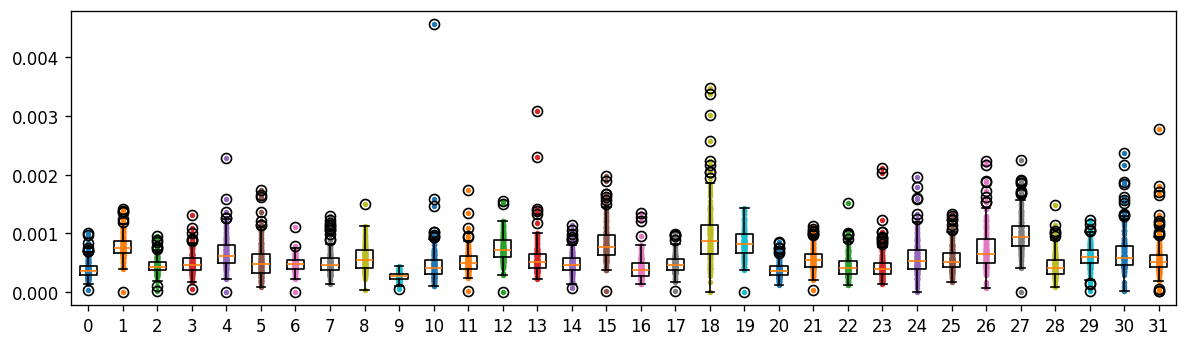

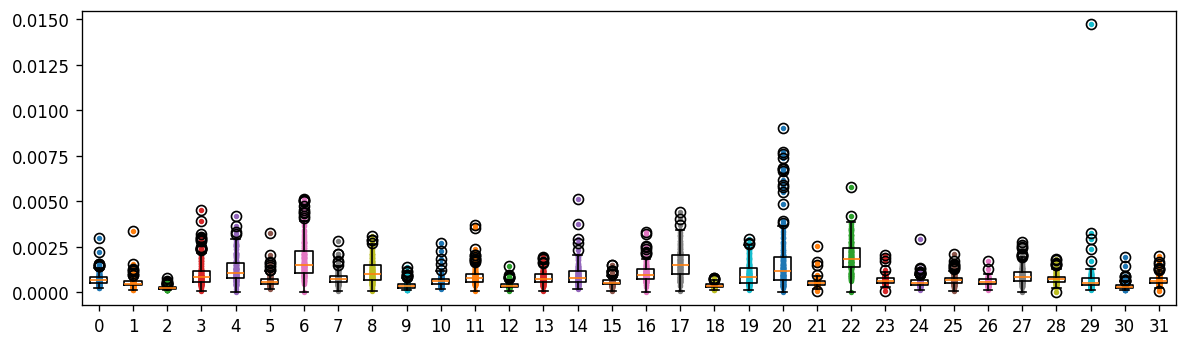

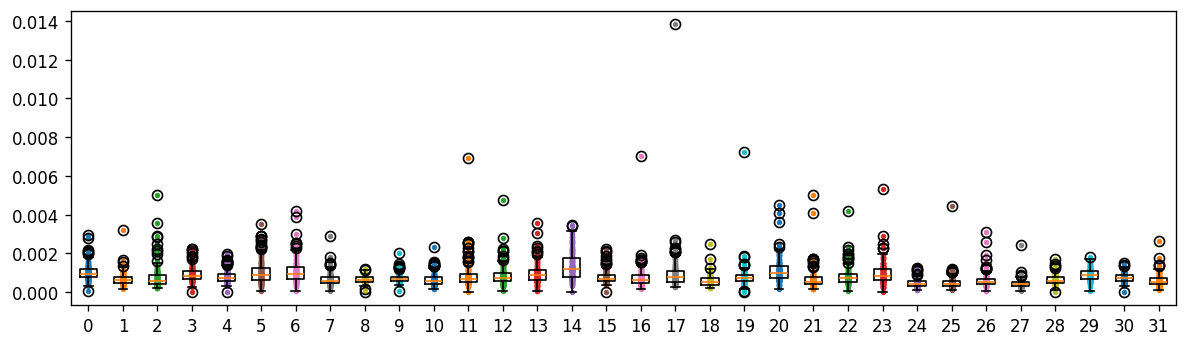

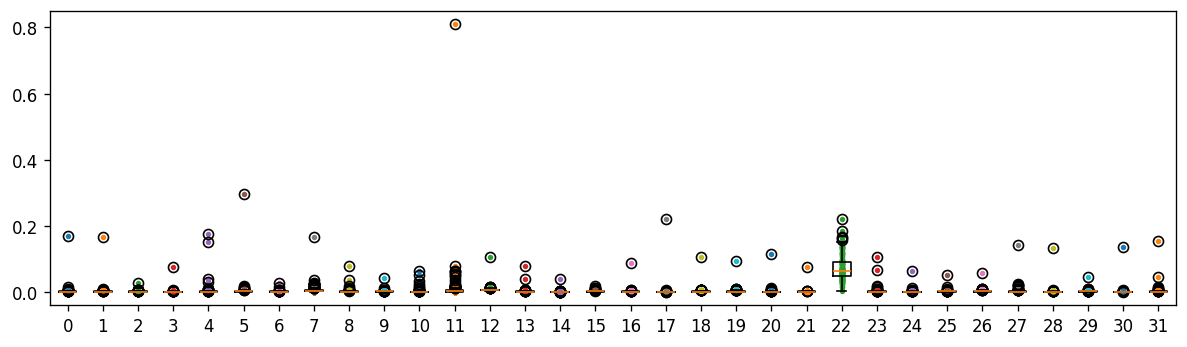

In [50]:
def compute_xentropies_for_all_heads_at_layer(layer, attention_matrices, attention_matrices_ref):
    xentropies_per_head = []
    
    # collect entropies when using causal attention
    for head in range(len(attention_matrices[layer])):
        H = scipy.stats.entropy(attention_matrices[layer, head], attention_matrices_ref[layer, head], axis=0)
        xentropies_per_head.append(H)
    
    return np.asarray(xentropies_per_head)

MODEL_1 = "meta-llama/Llama-2-7b-chat-hf"
# MODEL_1 = "mistralai/Mistral-7B-Instruct-v0.2"

MODEL_2 = "vaibhavad/llama-enc"
# MODEL_2 = "vaibhavad/mistral-enc"

LAYERS = 32
    
for layer in range(LAYERS)[:]:

    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10.0, 3.0), dpi=120)

    if layer >= num_layers:
        pass
    else:
        m1_data_path = f"/data/attention_data/{MODEL_1.split('/')[-1]}"
        m1_causal_attention_matrices = load_attention_matrices(m1_data_path, "causal", num_layers)
        m1_bi_attention_matrices = load_attention_matrices(m1_data_path, "bidirectional", num_layers)

        m2_data_path = f"/data/attention_data/{MODEL_2.split('/')[-1]}"
        m2_causal_attention_matrices = load_attention_matrices(m2_data_path, "causal", num_layers)
        m2_bi_attention_matrices = load_attention_matrices(m2_data_path, "bidirectional", num_layers)
        # print(m2_bi_attention_matrices.shape)

        # compute cross-entropy for each head and every token position
        # xH_b = compute_xentropies_for_all_heads_at_layer(layer, m1_bi_attention_matrices, m1_causal_attention_matrices + 1e-9) # causal vs. bi
        xH_b = compute_xentropies_for_all_heads_at_layer(layer, m2_bi_attention_matrices, m1_bi_attention_matrices) # bi vs. mntp

        for head in range(len(xH_b)):
            axes.boxplot(xH_b[head], positions=[head], widths=0.5, vert=True)
            axes.scatter([head] * len(xH_b[head]), xH_b[head], s=5)

    plt.tight_layout()
    plt.show()
    plt.close();
        